# Exercise 10 - Exercise statement
 Plot the detected communities in the US airport network and the Neural Network using each of the methods: Louvain, Girvan Newman, Fast Greedy and Label Propagation. Analyse the differences among the plots.

# Exercise 10 - Solution

Import the libraries that we'll use

In [1]:
import networkx as nx
from networkx.algorithms import community
from community import community_louvain
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import label_propagation_communities
from networkx.algorithms.community import asyn_lpa_communities
from networkx.algorithms.community.quality import modularity
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.linalg import expm
import pandas as pd
import time
from IPython.display import display, HTML, display_pretty
#import warnings
#warnings.simplefilter("ignore")

# A flag to use timer, just to prevent your system to freeze while running heavy processes
useTimer = False #this feature is disabled

Add some functions to help us

In [2]:
# Calculate the n-th moment of a probability distribution
def nth_moment_of_probability_distribution(xList, pxList, n):
    return expected_value([x**n for x in xList], pxList)

# Calculate the expected value of a random variable
def expected_value(xList, pxList):
    return sum([xList[i]*pxList[i] for i in range(len(xList))])

# Calculate the shannon entropy of an array of probabilities
def shannon_entropy(pxList):
    H = 0
    for p in pxList:
        if(p > 0):
            H = H - p*math.log(p, 2)
    return H

Create a class to encapsulate and do the graph operations

In [3]:
class Network:

    def __init__(self, name=None):
        self.name = name

    # Read graph from file and apply transformations
    def read_graph(self, inputFile):
        # To read the network from a file, we use the command read_edgelist.
        G= nx.read_edgelist(inputFile, comments='%', nodetype=int, data=(('weight',float),))
        # We transfor the network into the undirected version.
        G = G.to_undirected()
        # Here we consider only the largest component.
        Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
        G=Gcc[0]
        # Sometimes the node labels are not in the sequential order or strings are used. To facilitate our implementation, let us convert the labels to integers starting with the index zero, because Python uses 0-based indexing.
        G = nx.convert_node_labels_to_integers(G, first_label=0)
        # Save graph to the network
        self.graph = G
        return self.graph

    # Read graph from file and apply transformations
    def read_gml(self, inputFile):
        # To read the network from a file, we use the command read_edgelist.
        G = nx.read_gml(inputFile)
        # We transfor the network into the undirected version.
        G = G.to_undirected()
        # Here we consider only the largest component.
        Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
        G=Gcc[0]
        # Sometimes the node labels are not in the sequential order or strings are used. To facilitate our implementation, let us convert the labels to integers starting with the index zero, because Python uses 0-based indexing.
        G = nx.convert_node_labels_to_integers(G, first_label=0)
        # Save graph to the network
        self.graph = G
        return self.graph

    # Turn multigraph into graph
    def multiGraphToGraph(self):
        self.graph = nx.Graph(self.graph)

    # Store and return the transitivity of the graph
    def transitivity(self):
        return nx.transitivity(self.graph)

    # Store and return the average clustering coefficient of the graph
    def average_clustering(self):
        return nx.average_clustering(self.graph)

    # Get number of edges of the graph
    def number_of_edges(self):
        return self.graph.number_of_edges()

    # Get number of nodes of the graph
    def number_of_nodes(self):
        return len(self.graph)

    # Calculate average node degree
    def average_node_degree(self):
        # Get the degrees
        degrees = [d for n,d in self.graph.degree()]
        # Calculate the average
        return sum(degrees)/len(degrees)


    # Calculate the nth moment of degree distribution
    def nth_moment_of_degree_distribution(self, n):
        kvalues, pk = self.degree_distribution()
        return nth_moment_of_probability_distribution(kvalues, pk, n)

    # Calculate average shortest path length
    def average_shortest_path_length(self, weight=None):
        return nx.average_shortest_path_length(self.graph, weight)

    # Calculate diameter
    def diameter(self, e=None):
        return nx.diameter(self.graph, e)

    # Calculate assortativity coefficient
    def degree_assortativity_coefficient(self):
        return nx.degree_assortativity_coefficient(self.graph)

    def modularity(self, communities):
        return modularity(self.graph, communities)

    # Calculate degree distribution
    def degree_distribution(self):
        vk = dict(self.graph.degree())
        vk = list(vk.values())  # we get only the degree values
        vk = np.array(vk)
        maxk = np.max(vk)
        mink = np.min(vk)
        kvalues= np.arange(0,maxk+1) # possible values of k
        Pk = np.zeros(maxk+1) # P(k)
        for k in vk:
            Pk[k] = Pk[k] + 1
        Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
        return (kvalues, Pk)


    # Plot degree distribution
    def plot_degree_distribution(self):
        degree_distribution = self.degree_distribution()
        fig = plt.subplot(1,1,1)
        fig.set_xscale('log')
        fig.set_yscale('log')
        plt.suptitle(self.name, fontsize=16)
        plt.plot(degree_distribution[0], degree_distribution[1],'bo')
        plt.xlabel("k", fontsize=20)
        plt.ylabel("P(k)", fontsize=20)
        plt.title('Degree distribution', fontsize=20)
        plt.show(block=True)
        plt.clf()

    # Plot the graph
    def plot_graph(self):
        plt.figure(figsize=(10,10))
        pos=nx.spring_layout(self.graph)
        nx.draw(self.graph, with_labels = True, pos = pos)
        plt.show(block=True)
        plt.clf()

# Generate a graph for girvan newman benchmark
def benchmark_girvan_newman():
    N = 128
    tau1 = 3
    tau2 = 1.5
    mu = 0.04
    k =16
    minc = 32
    maxc = 32
    return LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = mu, min_degree = k,
                            max_degree = k, min_community=minc, max_community = maxc, seed = 10)

# Louvain's community detection method
def detect_communities_louvain(G):
    partition = community_louvain.best_partition(G)
    communities = list()
    for com in set(partition.values()) :
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        communities.append(sorted(list_nodes))
    return sorted(communities)

# Girvan Newman's community detection method
def detect_communities_girvan_newman(G):
    communities = community.girvan_newman(G)
    return sorted(sorted(c) for c in next(communities))

# Fast Greedy community detection method
def detect_communities_greedy(G):
    communities = greedy_modularity_communities(G)
    return sorted(map(sorted, communities))

# Label propagation community detection method
def detect_communities_label_propagation(G):
    communities = list()
    #for c in asyn_lpa_communities(G):
    for c in label_propagation_communities(G):
        communities.append(sorted(c))
    return sorted(communities)

# Plot graph with communities, receives a list of communities, where each community is a list of nodes (ints)
def show_communities(G, communities, name='title'):

    pos=nx.spring_layout(G)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    plt.figure()
    plt.title(name, fontsize=20)
    for i in range(len(communities)):
        if(i < len(colors)):
            nx.draw_networkx_nodes(G, pos, communities[i], node_size = 50, node_color = colors[i])
        else:
            nx.draw_networkx_nodes(G, pos, communities[i], node_size = 50, node_color = np.random.rand(3,))

    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show(block=True)


def main():

    # This line is a strange hack to prevent jupyter from sending a warning called:
    # [IPKernelApp] WARNING | WARNING: attempted to send message from fork
    # On github there is a similar issue still opened: <https://github.com/tqdm/tqdm/issues/485>
    print(' ', end='', flush=True)

    # List of files to open
    networkFiles = [
                    #'data/out.ca-AstroPh',
                    #'data/out.ego-facebook',
                    #'data/out.petster-friendships-hamster-uniq',
                    #'data/out.subelj_euroroad_euroroad',
                    'data/USairport500.txt'
                    #'data/out.maayan-vidal'
    ]

    # List of names of the networks
    networkNames = [
                    #'ArXiv’s Astrophysics',
                    #'Facebook user-user friendships',
                    #'Hamsterster friendships',
                    #'E-road network',
                    'US airport'
                    #'Human protein'
    ]

    # Load all networks

    # List of networks
    networks = []
    for i in range(len(networkNames)):
        # Load network
        networks.append(Network(name=networkNames[i]))
        networks[i].read_graph(networkFiles[i])
    # Read glm network
    networkNames.append('Neural Network')
    multiGraph =  Network(name=networkNames[-1])
    multiGraph.read_gml('data/celegansneural.gml')
    multiGraph.multiGraphToGraph()
    networks.append(multiGraph)

    # List of method names
    methodNames = [
        'Louvain',
        'Girvan Newman',
        'Fast Greedy',
        'Label Propagation'
    ]

    # List of community detection methods
    methods = [ detect_communities_louvain,
    detect_communities_girvan_newman,
    detect_communities_greedy,
    detect_communities_label_propagation
    ]

    # For each network
    for i in range(len(networkNames)):
        # Get current network
        network = networks[i]

        for j in range(len(methodNames)):
            # Gets community from graph using method[j]
            community = methods[j](network.graph)
            # Make plot title
            plotTitle = networkNames[i] + ' - ' + methodNames[j]
            # Plot graph with its communities and name it
            #show_communities(G, result, name=method.__name__[19:])
            show_communities(network.graph, community, name=plotTitle)

Here we create a process to run the main function. The advantage of using this strategy, instead of directly invoking main(), is that it gives us more control to stop the program.
 If we set the useTimer variable at the beginning of the program to True, the timer will stop the main process after 60 seconds. It's useful when we hit Ctrl+C in the terminal and the program refuses to stop.
 Also, it's important to catch the KeyboardInterrupt exception, that is raised when we hit Ctrl+C.
 By default, Ctrl+C would kill our program and the process that we've created would still continue to run.
 When we catch the exception, we also terminate the process of the function main. This way, Ctrl+C works again.

/home/flaviokc/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


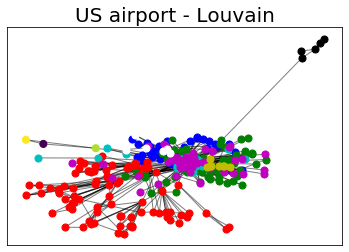

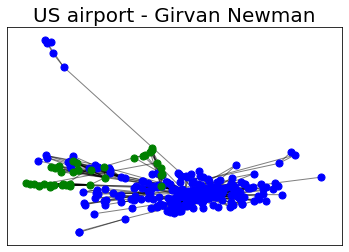

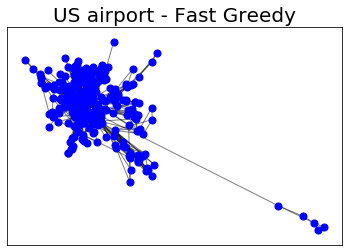

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

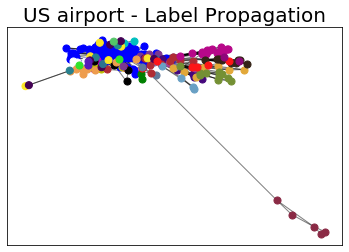

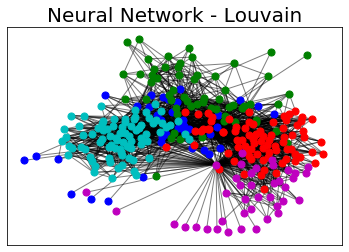

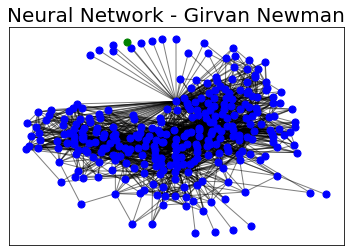

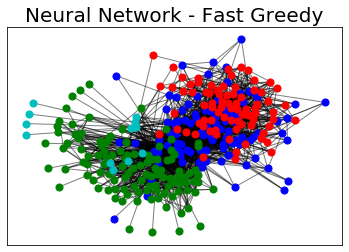

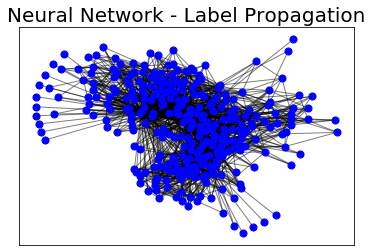

In [4]:
from multiprocessing import Process
from threading import Timer
if __name__ == "__main__":
    # Create the main process
    proc = Process(target=main)

    # Use timer if set
    if(useTimer):
        #declare timer, it gets the time in seconds
        timer = Timer(300, proc.terminate)
        timer.start()

    try:
        # Start process
        proc.start()

        # Block until process terminate
        proc.join()
    except KeyboardInterrupt:
        proc.terminate()

    # If process ends in time, cancel timer
    if(useTimer):
        timer.cancel()

Now we can see the beautiful community detection with colors. For the Neural Network, it's visible that the Girvan Newman's method and the label propagation detection method had a bad modularity for the networks, because they classified almost all nodes in the same class. While with Louvain and Fast Greedy methods, we see well defined classes with reasonable modularity.
 Using the same criteria, it's visible when the methods had good modularity on the US airport network and when they didn't.